# Noise2Void Image Denoising
This notebook demonstrates how to use the Noise2Void (N2V) model to denoise images.

In [1]:
!pip install tensorflow==2.10
!pip install n2v
!pip install scikit-image
!nvidia-smi


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached google_auth-2.29.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.m

## Environment Setup

In [1]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-06-03 18:29:18.668516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 18:29:19.264351: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 18:29:20.461967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib64:/usr/local/cuda-12.1/bin/lib64:/usr/lib/x86_64-linux-gnu/:/usr/lib/R/modules/:/usr/local/lib
2024-06-03 18:29:20.462087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] 

2.10.0
0.3.3
Num GPUs Available:  1


2024-06-03 18:29:22.217133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 18:29:22.327138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 18:29:22.330349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Import Dependencies

In [9]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from matplotlib import pyplot as plt
from skimage import io, util
from tifffile import imread, imsave
import os
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Check current working directory
#print(os.getcwd())

# Set working directory if necessary
#os.chdir('./Documents/BioCampus_MDL_2024/exercises/python')
#print(os.getcwd())  # Verify the change

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Verify the mount
!ls /content/drive/My\ Drive

ModuleNotFoundError: No module named 'google.colab'

## Data Preparation

Number of images loaded: 3


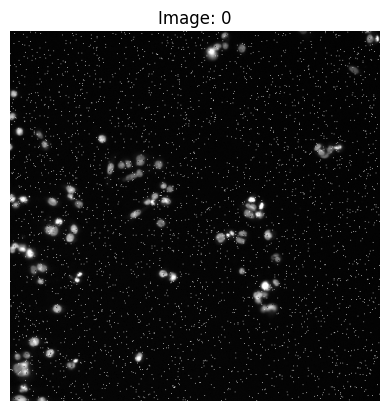

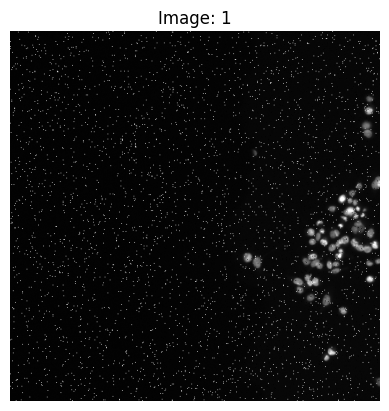

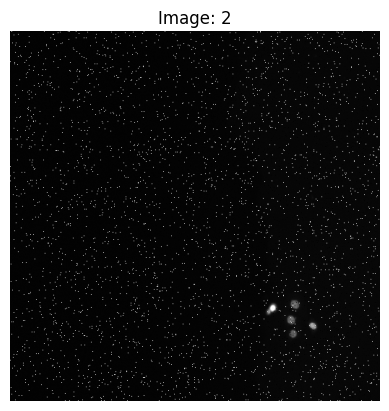

Example image shape: (1, 512, 512, 1)


In [2]:
# Create DataGenerator object
datagen = N2V_DataGenerator()

# Paths to downloaded images
input_folder = '/home/cedric/Documents/BioCampus_MDL_2024/exercises/python/N2V/images/noisy-imgs/'

# Load images
images = datagen.load_imgs_from_directory(directory=input_folder, filter='*.tif', dims='YX')
# Display the number of images loaded
print(f'Number of images loaded: {len(images)}')

# Display a few images for verification
for i in range(min(3, len(images))):
    plt.figure()
    plt.imshow(np.squeeze(images[i]), cmap='gray')
    plt.title(f'Image: {i}')
    plt.axis('off')
    plt.show()

# Check the dimensions of the images
print(f"Example image shape: {images[0].shape}")

## Patch Generation

Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches shape: (1536, 64, 64, 1)
Training patches shape: (1228, 64, 64, 1)
Validation patches shape: (308, 64, 64, 1)


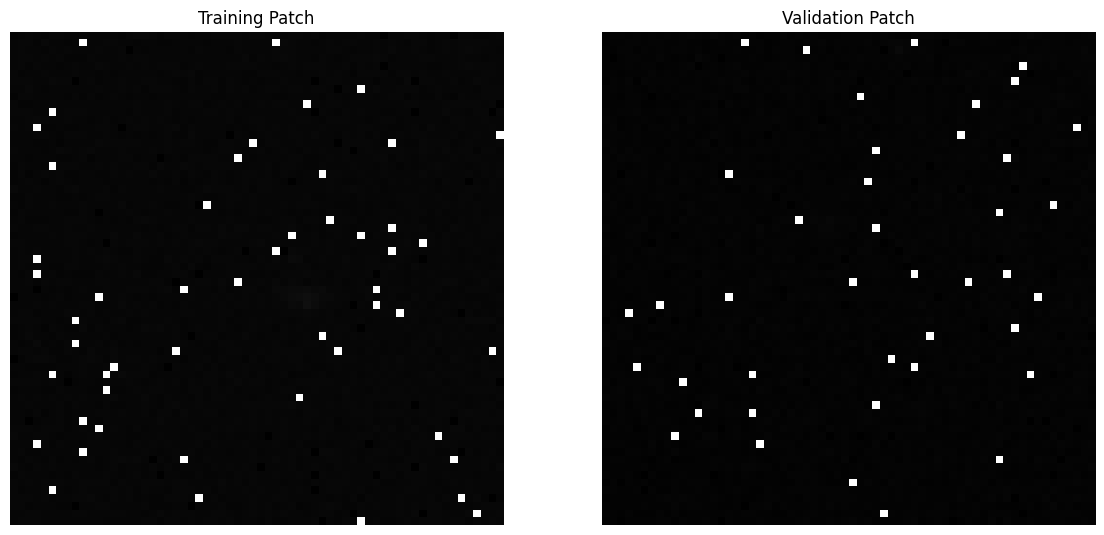

In [3]:
# Extract patches from images using generate_patches_from_list
patch_size = 64
patches = datagen.generate_patches_from_list(images, shape=(patch_size, patch_size), augment=True, shuffle=True)

# Check the shape of the generated patches
if patches is None:
    raise ValueError("Patch generation failed, patches is None.")
else:
    print(f"Generated patches shape: {patches.shape}")

# Split into training and validation sets
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

print(f'Training patches shape: {X.shape}')
print(f'Validation patches shape: {X_val.shape}')

# Display two patches for verification
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(X[0]), cmap='gray')
plt.title('Training Patch')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.squeeze(X_val[0]), cmap='gray')
plt.title('Validation Patch')
plt.axis('off')
plt.show()

## Model Configuration and Training

{'means': ['263.8197'], 'stds': ['502.53268'], 'n_dim': 2, 'axes': 'YXC', 'n_channel_in': 1, 'n_channel_out': 1, 'unet_residual': False, 'unet_n_depth': 3, 'unet_kern_size': 3, 'unet_n_first': 16, 'unet_last_activation': 'linear', 'unet_input_shape': (None, None, 1), 'train_loss': 'mse', 'train_epochs': 50, 'train_steps_per_epoch': 38, 'train_learning_rate': 0.001, 'train_batch_size': 32, 'train_tensorboard': True, 'train_checkpoint': 'weights_best.h5', 'train_reduce_lr': {'factor': 0.5, 'patience': 10}, 'batch_norm': True, 'n2v_perc_pix': 0.198, 'n2v_patch_shape': (64, 64), 'n2v_manipulator': 'uniform_withCP', 'n2v_neighborhood_radius': 5, 'single_net_per_channel': False, 'blurpool': False, 'skip_skipone': False, 'structN2Vmask': None, 'probabilistic': False, 'train_reduce_lr_on_plateau': True, 'train_reduce_lr_factor': 0.5, 'train_reduce_lr_patience': 5}


/home/cedric/anaconda3/envs/N2V/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /home/cedric/Documents/BioCampus_MDL_2024/exercises/python/N2V/models/n2v_noisy
  warnings.warn(
2024-06-03 19:44:19.326976: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-03 19:44:19.327009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: phoenix
2024-06-03 19:44:19.327016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: phoenix
2024-06-03 19:44:19.327116: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-06-03 19:44:19.327136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-06-03 19:44:19.327141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel ver

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|████████████| 308/308 [00:00<00:00, 3278.93it/s]

Epoch 1/50


38/38 [==============================] - 12s 285ms/step - loss: 1.2093 - n2v_mse: 1.2093 - n2v_abs: 0.6662 - val_loss: 0.9700 - val_n2v_mse: 0.9774 - val_n2v_abs: 0.3187 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - 10s 265ms/step - loss: 0.8149 - n2v_mse: 0.8149 - n2v_abs: 0.3237 - val_loss: 0.9149 - val_n2v_mse: 0.9237 - val_n2v_abs: 0.2817 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 10s 265ms/step - loss: 0.7565 - n2v_mse: 0.7565 - n2v_abs: 0.2582 - val_loss: 0.8536 - val_n2v_mse: 0.8633 - val_n2v_abs: 0.2603 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - 10s 265ms/step - loss: 0.8167 - n2v_mse: 0.8167 - n2v_abs: 0.2572 - val_loss: 0.8424 - val_n2v_mse: 0.8521 - val_n2v_abs: 0.2420 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - 10s 265ms/step - loss: 0.7663 - n2v_mse: 0.7663 - n2v_abs: 0.2327 - val_loss: 0.8407 - val_n2v_mse: 0.8509 - val_n2v_abs: 0.2283 - lr: 0.0010
Epoch 6/50
38/38 [=======================

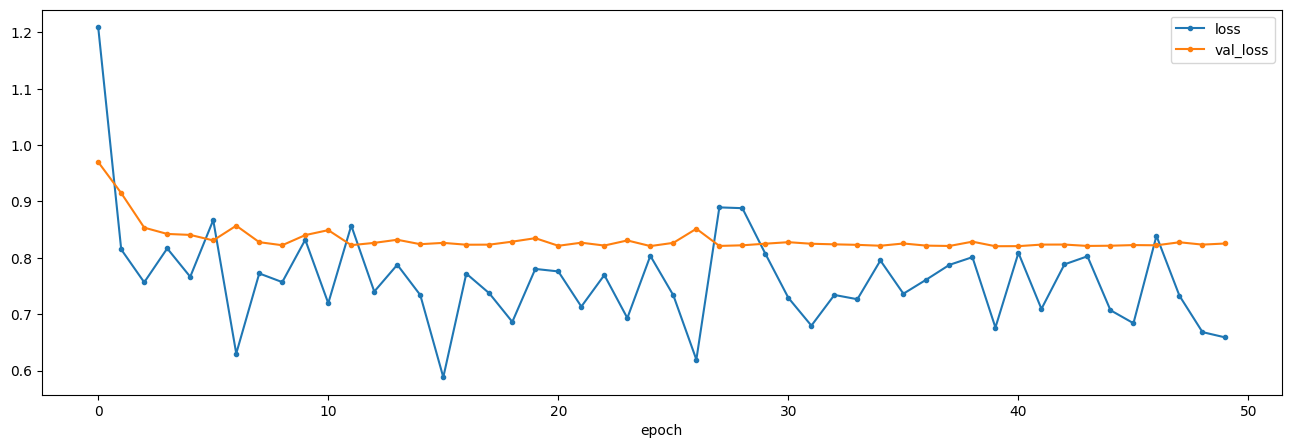

In [4]:
# Configure the N2V model
train_batch = 32  # Batch size
config = N2VConfig(X, 
                   unet_kern_size=3, 
                   unet_n_first=16,  # Number of initial filters
                   unet_n_depth=3,  # Network depth
                   train_steps_per_epoch=int(X.shape[0] / train_batch), 
                   train_epochs=50,  # Number of epochs
                   train_loss='mse', 
                   batch_norm=True, 
                   train_batch_size=train_batch, 
                   n2v_perc_pix=0.198, 
                   n2v_patch_shape=(patch_size, patch_size), 
                   n2v_manipulator='uniform_withCP', 
                   n2v_neighborhood_radius=5, 
                   single_net_per_channel=False,
                   train_learning_rate=0.001,  # Initial learning rate
                   train_reduce_lr_on_plateau=True,  # Reduce learning rate on plateau
                   train_reduce_lr_factor=0.5,  # Learning rate reduction factor
                   train_reduce_lr_patience=5)  # Patience before reducing learning rate

# Check the parameters stored in the config object
print(vars(config))

# Define the model name and directory
model_name = 'n2v_noisy'
basedir = 'models'
model = N2V(config, model_name, basedir=basedir)

# Train the model
history = model.train(X, X_val)

# Plot training history
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history, ['loss', 'val_loss'])

## Image Denoising

Loading network weights from 'weights_best.h5'.
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 239ms/step


/tmp/ipykernel_11266/1582190427.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(save_path, pred)


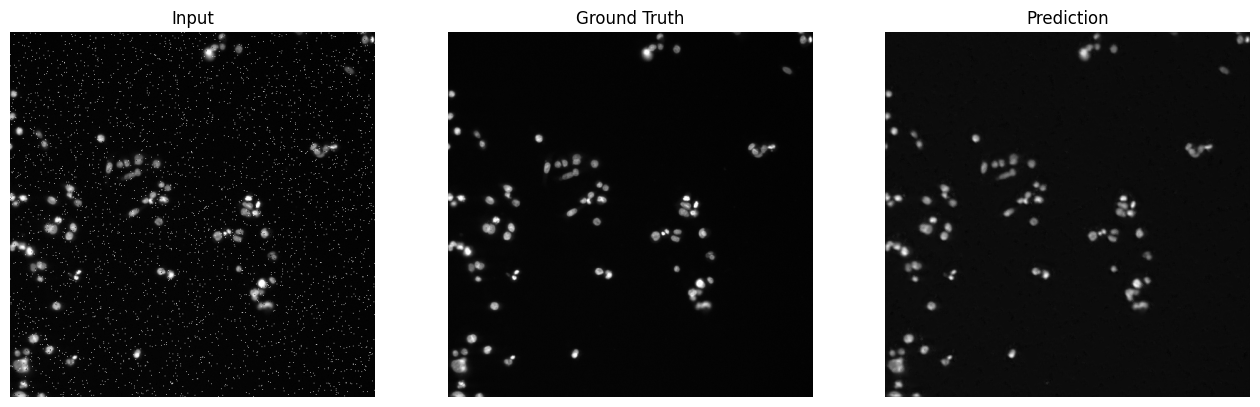

Image noisy-img-1.tif - PSNR: 34.43, SSIM: 0.9439
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 84ms/step


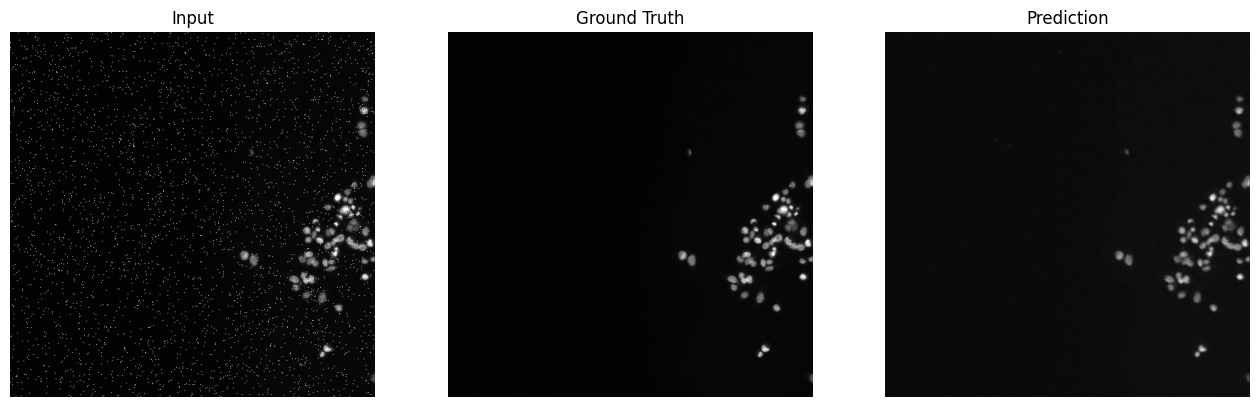

Image noisy-img-2.tif - PSNR: 36.34, SSIM: 0.9424
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 83ms/step


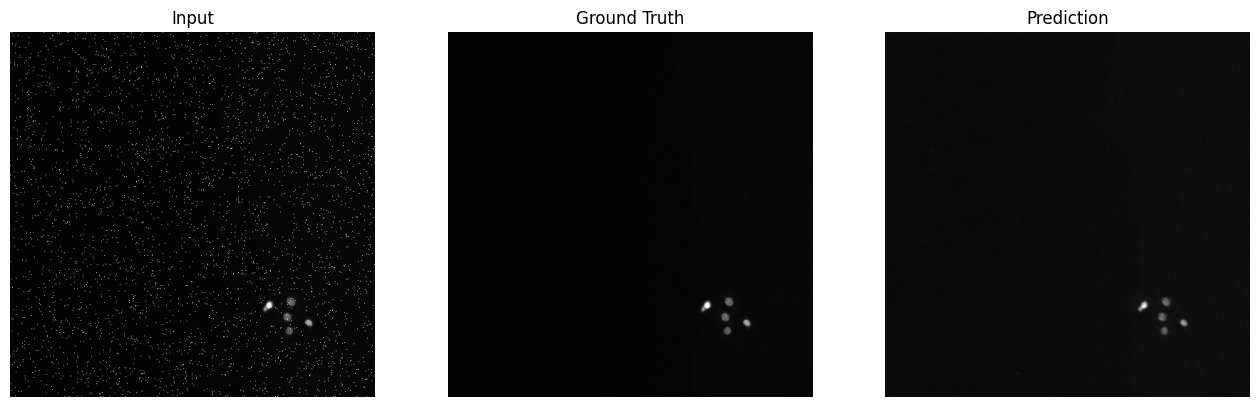

Image noisy-img-3.tif - PSNR: 38.64, SSIM: 0.9452
Average PSNR: 36.47, Average SSIM: 0.9438


In [17]:
# Load the trained model
model = N2V(config=None, name=model_name, basedir=basedir)

input_folder = '/home/cedric/Documents/BioCampus_MDL_2024/exercises/python/N2V/images/noisy-imgs/'
output_folder = '/home/cedric/Documents/BioCampus_MDL_2024/exercises/python/N2V/images/denoised/'
ground_truth_folder = '/home/cedric/Documents/BioCampus_MDL_2024/exercises/python/N2V/images/ground-truth/'

def denoise_and_save(input_folder, ground_truth_folder, model, output_folder):
    # List .tif files in the input folder and ground truth folder
    tif_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tif')])
    ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) if f.endswith('.tif')])
    
    psnr_values = []
    ssim_values = []

    for i, (input_file, gt_file) in enumerate(zip(tif_files, ground_truth_files)):
        input_path = os.path.join(input_folder, input_file)
        gt_path = os.path.join(ground_truth_folder, gt_file)
        
        # Load the image
        test_image = imread(input_path)
        ground_truth_image = imread(gt_path)
        
        # Normalize the images if necessary
        data_range = test_image.max() - test_image.min()
        
        # Denoise the image (prediction)
        pred = model.predict(test_image, axes='YX')
        
        # Save the denoised image with the original filename
        save_path = os.path.join(output_folder, input_file)
        imsave(save_path, pred)
        
        # Compute metrics
        psnr_value = peak_signal_noise_ratio(ground_truth_image, pred, data_range=data_range)
        ssim_value = structural_similarity(ground_truth_image, pred, data_range=data_range)
        
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        
        # Display the results
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(test_image), cmap='gray')
        plt.title('Input')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(ground_truth_image), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        
        plt.show()
        
        print(f'Image {input_file} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}')

    # Print average metrics
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    print(f'Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}')

# Denoise and save images from the input folder
denoise_and_save(input_folder, ground_truth_folder, model, output_folder)
